## Import Libraries

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Gdal Raster Processing

In [5]:
filename = "data/AletschGlacierDEM.tiff"
gdata = gdal.Open(filename)
print(gdata.GetGeoTransform())

(637342.9875465514, 24.999899583000516, 0.0, 154037.85892408466, 0.0, -24.999899583000516)


In [16]:
gdal_band = gdata.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
print(gdata.RasterXSize, gdata.RasterYSize)

693 720


In [17]:
g = gdata.ReadAsArray().astype('float64')
# replace missing values if necessary
if np.any(g == nodataval):
    g[g == nodataval] = np.nan

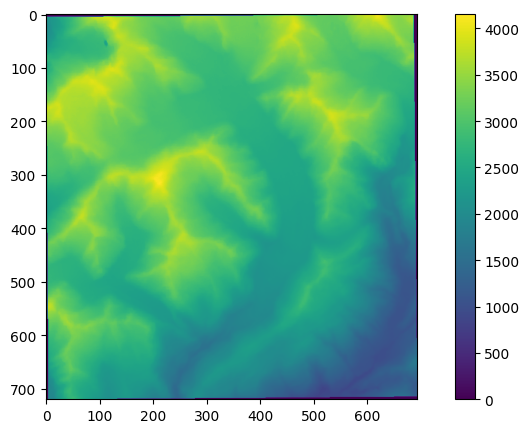

In [18]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)
plt.imshow(g)
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().invert_yaxis()
plt.show()

## Point Cloud Generation

In [ ]:
GTransf = gdata.GetGeoTransform()

points = []

for j_vertical in range(g.shape[0]):
    for i_horizental in range(g.shape[1]):
        
        x= (i_horizental)*GTransf[1] + (j_vertical)*GTransf[2] + GTransf[0]
        y= (i_horizental)*GTransf[4] + (j_vertical)*GTransf[5] + GTransf[3]
        z= g[j_vertical,i_horizental]
        points.append([x,y,z])
points = np.array(points) 

# np.savetxt('large-size-data/Mountain_PointCloud_no_deletion.out', points, delimiter=',')

In [19]:
points = np.loadtxt('large-size-data/Mountain_PointCloud_no_deletion.out', delimiter=',')
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

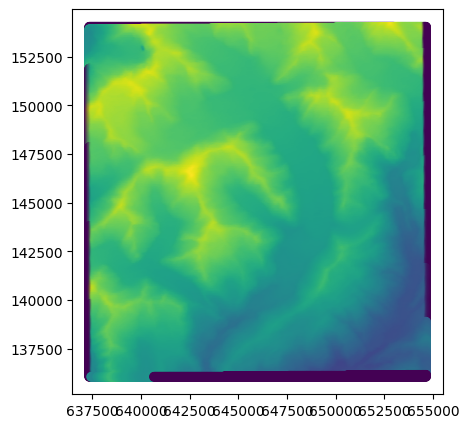

In [26]:
fig = plt.figure(figsize = (10, 5))
plt.scatter(points[:,0],points[:,1], c=points[:,2])
plt.axis('scaled')
plt.show()

In [22]:
def Custom_Visualizer_Mesh(obj):
    width=1820
    vis = o3d.visualization.Visualizer()
    vis.create_window('Open3D', width, height=980,
                      left=int(0.5*(1920-width)), top=35, visible=True)
    vis.add_geometry(obj)

    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    vis.run()
    vis.destroy_window()


Custom_Visualizer_Mesh(pcd)

In [32]:
DEM_Image = ((g/g.max())*255).astype('uint8')
cv2.imwrite('data/DEM_Image_Gray_No_deletion.jpg', DEM_Image)

True

## DEM Image Keypoints

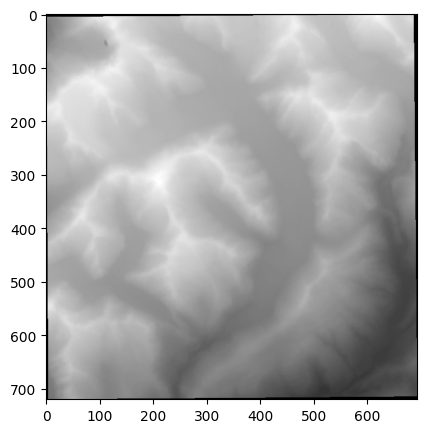

In [34]:
DEM_Image = cv2.imread('data/DEM_Image_Gray_No_deletion.jpg', cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize = (10, 5))
plt.imshow(DEM_Image, cmap='gray')
plt.show()

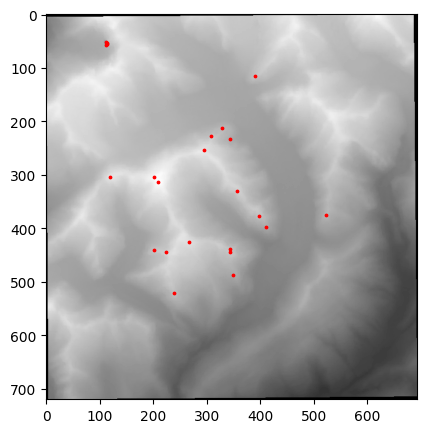

In [39]:
orb = cv2.ORB_create(nfeatures = 1000, scaleFactor = 1.9, nlevels = 8, edgeThreshold = 31,
                     firstLevel = 0, WTA_K = 4, scoreType = 0 , patchSize = 31,
                     fastThreshold = 10 )

orb_keypoints, orb_des = orb.detectAndCompute(DEM_Image, None)

if len(orb_keypoints)==0: print("no keypoint founded")
else:
    orb_kp = np.array([i.pt for i in orb_keypoints])

    fig = plt.figure(figsize = (10, 5))
    plt.imshow(DEM_Image, cmap='gray')
    plt.scatter(orb_kp[:,0],orb_kp[:,1], c='red', s=3)
#     plt.gca().invert_yaxis() ######################################
#     plt.gca().invert_xaxis()
    #plt.title('Number of Keypoints = '+ str(orb_kp.shape[0]))
    
    
#     for i in range(orb_kp.shape[0]):
#         margin = orb_kp[i,0]*0.05
#         plt.text(orb_kp[i,0]+margin, orb_kp[i,1], str(i),
#                 horizontalalignment='left', size='large', color='blue', weight='semibold')
    
#     plt.grid()
    plt.show()

np.savetxt('data/DEM_Raster_keypoint.out', orb_kp, delimiter=',')

## Extract Geo Keypoints

In [42]:
def ImgKeyPoints_To_GeoKeyPoints(ImgKeyPoints, DEM_DataArray, GDAL_GeoTransform):
    
    ImgKeyPoints_indices = ImgKeyPoints.round(0).astype('int64')
    
    GeoKeyPoints = []
    for i_horizental,j_vertical in ImgKeyPoints_indices:
        
        x= (i_horizental)*GTransf[1] + (j_vertical)*GTransf[2] + GTransf[0]
        y= (i_horizental)*GTransf[4] + (j_vertical)*GTransf[5] + GTransf[3]
        z= DEM_DataArray[j_vertical,i_horizental]
        
        GeoKeyPoints.append([x,y,z])
    GeoKeyPoints = np.array(GeoKeyPoints)
    return GeoKeyPoints

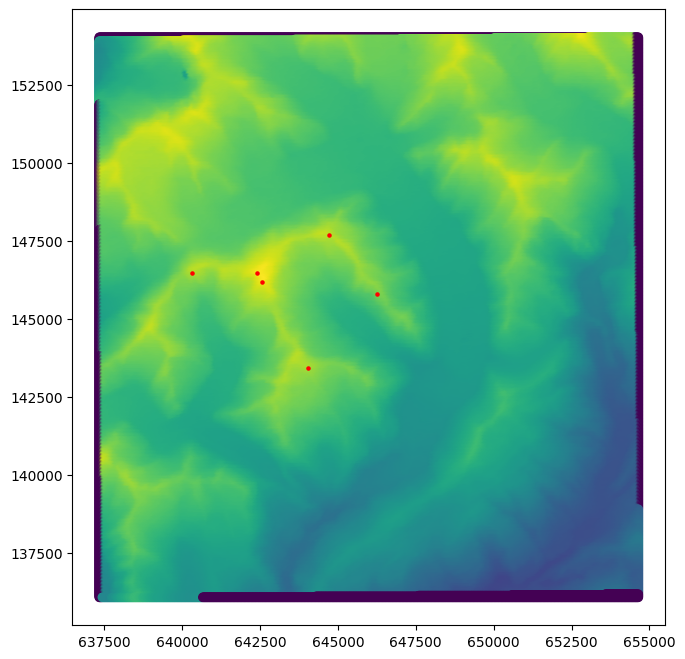

In [47]:
GTransf = gdata.GetGeoTransform()
Geo_Keypoints = ImgKeyPoints_To_GeoKeyPoints(orb_kp, g, GTransf)

highestElev_index = np.argsort(-Geo_Keypoints[:,2])[0:6]

fig = plt.figure(figsize = (12, 8))
plt.scatter(points[:,0],points[:,1], c=points[:,2])
plt.scatter(Geo_Keypoints[highestElev_index][:,0], Geo_Keypoints[highestElev_index][:,1], c='red', s=5)
plt.axis('scaled')
plt.show()

In [46]:
np.savetxt('data/Geo_Keypoints_no_deletion.out', Geo_Keypoints, delimiter=',')